In [2]:
import numpy as np
from time import time
from matplotlib import pyplot as plt
import pandas as pd
from sklearn import datasets, metrics, svm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, MaxPooling1D, Conv2D, Reshape
from tensorflow.keras import losses, optimizers
import os, sys, csv
from tqdm import tqdm
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import motor
sys.path.append('../../')
from data_loader import get_dataset, get_label

hyperparameters

In [3]:
epoch_size = 200
batch_size = 150
repeat = 100

### Load Data

In [4]:
# data_dim_MFCC = 13
# trSampleRatio = 0.85
# data_dim_CWT = 13
# data_dim_DWT = 13
data_dim_LPC = 13

data_cfg = {
    "dataType" : "LPC",      # raw, MFCC, LPC, PLP, CWT, DWT
    "division" : "both",   # whole, steady, transient, both
    "dataDimension" : data_dim_LPC
}

In [5]:
data_steady = get_dataset({"dataType":"LPC", "division":"steady", "dataDimension":data_dim_LPC})
data_transient = get_dataset({"dataType":"LPC", "division":"transient", "dataDimension":data_dim_LPC})
data_whole = np.append(data_steady, data_transient, 1)

In [6]:
# data_whole = get_dataset(data_cfg)
y_whole = get_label()

### Build Classifier Model

In [7]:
def buildmodel(type, data_cfg):
    if data_cfg["division"] == "both":
        n_features = 2
    else:
        n_features = 1
    print(f'n_features is {n_features} (data_cfg["division"] is \"{data_cfg["division"]}\")')    
    if type == "CNN":
        n_channel = [16, 20, 30]
        #with tf.device('/gpu:1'):
        tf.keras.backend.clear_session()
        model = Sequential()
        model.add(Conv1D(filters = n_channel[0], kernel_size = 3, activation = 'relu', input_shape = [motor.data_dim_MFCC, n_features], padding = 'same'))
        model.add(Conv1D(filters = n_channel[0], kernel_size = 3, activation = 'relu', padding = 'valid'))
        model.add(Conv1D(filters = n_channel[0], kernel_size = 3, activation = 'relu', padding = 'valid'))
        model.add(Flatten(name="feature_extraction"))
        model.add(Dense(1, activation = 'sigmoid'))

        model.compile(loss = losses.mean_squared_error, optimizer = optimizers.Adam(0.001))

        Wsave = model.get_weights()
        return model, Wsave

In [8]:
    model, Wsave = buildmodel("CNN", data_cfg)
    print(model.summary())

n_features is 2 (data_cfg["division"] is "both")
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 13, 16)            112       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 16)            784       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 9, 16)             784       
_________________________________________________________________
feature_extraction (Flatten) (None, 144)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 145       
Total params: 1,825
Trainable params: 1,825
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
def get_AUC(y_trues, y_predictions):
    fpr, tpr, thresholds = metrics.roc_curve(y_trues, y_predictions, pos_label=1)
    AUC = metrics.auc(fpr, tpr)
    return AUC, fpr, tpr

In [10]:
AUCs = np.array([])
for _ in tqdm(range(repeat)):
    [train_data, train_label, test_data, test_label] = motor.resampleData(data_whole, y_whole)
    model.set_weights(Wsave)
    [y_predictions, y_trues] = motor.fitClassifier_y_pred(model, train_data,train_label,test_data,test_label, epoch_size, batch_size)
    
    AUC, fpr, tpr = get_AUC(y_trues, y_predictions)
    AUCs = np.append(AUCs, AUC)

100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


In [11]:
def plot_roc(fpr, tpr):
    AUC = metrics.auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % AUC)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
print("AUCs:", AUCs)
print("mean:{}  std:{}".format(np.mean(AUCs),np.std(AUCs)))

AUCs: [0.78333333 0.75833333 0.86666667 0.80833333 0.79166667 0.9
 0.85833333 0.89166667 0.93333333 0.84166667 0.775      0.94166667
 0.625      0.83333333 0.85       0.8        0.84166667 0.69166667
 0.775      0.76666667 0.725      0.70833333 0.875      0.78333333
 0.95       0.8        0.74166667 0.9        0.88333333 0.90833333
 0.725      0.76666667 0.76666667 0.875      0.84166667 0.75
 0.75833333 0.9        0.68333333 0.79166667 0.93333333 0.81666667
 0.85       0.78333333 0.79166667 0.88333333 0.66666667 0.925
 0.75       0.84166667 0.75833333 0.88333333 0.59166667 0.76666667
 0.73333333 0.88333333 0.925      0.58333333 0.79166667 0.83333333
 0.75833333 0.80833333 0.725      0.75833333 0.64166667 0.71666667
 0.94166667 0.84166667 0.95       0.99166667 0.80833333 0.88333333
 0.64166667 0.74166667 0.86666667 0.625      0.73333333 0.76666667
 0.95       0.85833333 0.76666667 0.85       0.825      0.91666667
 0.71666667 0.88333333 0.88333333 0.8        0.85833333 0.725
 0.9        

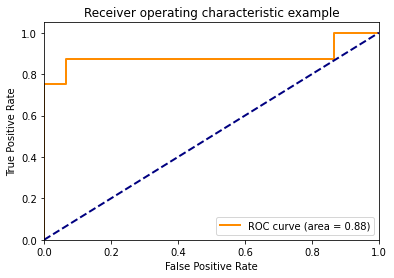

In [13]:
plot_roc(fpr, tpr)

#### 1. not divided

In [14]:
# n_features = 1
# data_whole = motor.load_MFCC_whole()
# data_whole = motor.load_CWT_whole()

#### 2. transient phase

In [15]:
# n_features = 1
# data_whole = motor.load_MFCC_transient()
# data_whole = motor.load_CWT_transient()

#### 3. steady-state phase

In [16]:
# n_features = 1
# data_whole = motor.load_MFCC_steady()

#### 4. both transient & steady-state phase

In [17]:
# n_features = 2
# data_MFCC_only_steady = motor.load_MFCC_steady()
# data_MFCC_only_transient = motor.load_MFCC_transient()
# data_whole = np.append(data_MFCC_only_steady, data_MFCC_only_transient, 1)

In [18]:
# model, Wsave = buildCNNmodel()

### MLP classifier

In [19]:
# def buildMLPmodel():
#     n_fc = [16, 8]
#     #with tf.device('/gpu:1'):
#     tf.keras.backend.clear_session()
#     model = Sequential()

#     model.add(Dense(n_fc[0], activation = 'relu', input_dim = motor.data_dim_MFCC * n_features))
#     model.add(Dense(n_fc[0], activation = 'relu'))
#     model.add(Dense(n_fc[0], activation = 'relu'))
#     model.add(Dense(n_fc[0], activation = 'relu'))
#     model.add(Dense(n_fc[1], activation = 'relu', name="feature_extraction"))
#     model.add(Dense(1, activation = 'sigmoid'))

#     model.compile(loss = losses.mean_squared_error, optimizer = optimizers.Adam(0.001))

#     Wsave = model.get_weights()
#     print(model.summary())
#     return model, Wsave

In [20]:
# model, Wsave = buildMLPmodel()

### CNN training

In [21]:
# AUCs = np.array([])
# for _ in tqdm(range(repeat)):
#     [train_data, train_label, test_data, test_label] = motor.resampleData(data_whole, y_whole)
#     model.set_weights(Wsave)
#     [y_predictions, y_trues] = motor.fitClassifier_y_pred(model, train_data,train_label,test_data,test_label, epoch_size, batch_size)
    
#     fpr, tpr, thresholds = metrics.roc_curve(y_trues, y_predictions, pos_label=1)
#     AUC = metrics.auc(fpr, tpr)
#     AUCs = np.append(AUCs, AUC)
# #     [tp, tn, fp, fn] = fitClassifier_y_pred(train_data,train_label,test_data,test_label)
    
# #     print("true_positive: {:d}".format(tp) + "\t true_negative: {:d}".format(tn))
# #     print("false_positive: {:d}".format(fp) + "\t false_negative: {:d}".format(fn))
    
# #     tp_tot += tp; tn_tot += tn; fp_tot += fp; fn_tot += fn

### MLP training

In [22]:
# AUCs = np.array([])
# for repeat in range(100):
#     [train_data, train_label, test_data, test_label] = motor.resampleData(data_whole, y_whole)
#     model.set_weights(Wsave)
#     [y_predictions, y_trues] = motor.fitClassifier_y_pred_MLP(model, train_data,train_label,test_data,test_label, epoch_size, batch_size)
    
#     fpr, tpr, thresholds = metrics.roc_curve(y_trues, y_predictions, pos_label=1)
#     AUC = metrics.auc(fpr, tpr)
#     AUCs = np.append(AUCs, AUC)

### SVM training

In [23]:
# AUCs = np.array([])
# for repeat in range(100):
#     [train_data, train_label, test_data, test_label] = motor.resampleData(data_whole, y_whole)
    
#     clf = svm.SVC(random_state=0, probability=True)
#     clf.fit(train_data, train_label)
    

#     y_predictions = clf.predict(test_data)
#     y_predict_proba = clf.predict_proba(test_data)
#     fpr, tpr, thresholds = metrics.roc_curve(test_label, y_predict_proba[:,1], pos_label=1)
#     AUC = metrics.auc(fpr, tpr)
#     AUCs = np.append(AUCs, AUC)    
    
# metrics.plot_roc_curve(clf, test_data, test_label)  
    
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % AUC)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

In [24]:
# print(train_label)
# train_prediction = clf.predict(train_data)
# print(train_prediction)
# print(y_predict_proba)
# print(test_label)
# print(y_predictions)

In [25]:
# print("true_positive: {:d}".format(tp_tot) + "\t true_negative: {:d}".format(tn_tot))
# print("false_positive: {:d}".format(fp_tot) + "\t false_negative: {:d}".format(fn_tot))

In [26]:
# fpr, tpr, thresholds = metrics.roc_curve(y_trues, y_predictions, pos_label=1)
# metrics.auc(fpr, tpr)

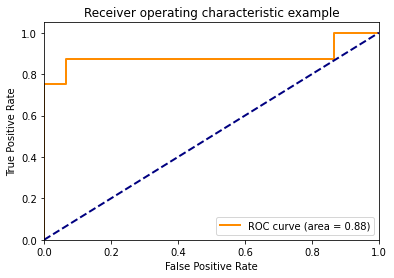

In [27]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [28]:
fpr

array([0.        , 0.        , 0.        , 0.06666667, 0.06666667,
       0.86666667, 0.86666667, 1.        ])

In [29]:
tpr

array([0.   , 0.125, 0.75 , 0.75 , 0.875, 0.875, 1.   , 1.   ])

In [30]:
thresholds

NameError: name 'thresholds' is not defined

In [ ]:
# metrics.plot_roc_curve(clf, X_test, y_test)  
# plt.show()                           

### feature extracted at the last layer

In [ ]:
# # output of last layer
# feature_extractor = tf.keras.Model(
#     inputs=model.inputs,
#     outputs=model.get_layer(name="feature_extraction").output,
# )

# train_features = feature_extractor(np.transpose(np.reshape(train_data, [-1, n_features, motor.data_dim_MFCC]), [0, 2, 1]))
# test_features = feature_extractor(np.transpose(np.reshape(test_data, [-1, n_features, motor.data_dim_MFCC]), [0, 2, 1]))
# whole_features = feature_extractor(np.transpose(np.reshape(data_whole, [-1, n_features, motor.data_dim_MFCC]), [0, 2, 1]))

In [ ]:
# whole_features

In [ ]:
# train_features

In [ ]:
# train_label

In [ ]:
# test_features

In [ ]:
# test_label

In [ ]:
# np.savetxt("feature_extraction_MFCConly_whole.txt",whole_features)

In [ ]:
# # Make a model with 2 layers
# layer1 = tf.keras.layers.Dense(3, activation="relu")
# layer2 = tf.keras.layers.Dense(3, activation="sigmoid")
# model = tf.keras.Sequential([tf.keras.Input(shape=(3,)), layer1, layer2])

# # Freeze the first layer
# layer1.trainable = False

# print("weights:", len(layer1.weights))
# print("trainable_weights:", len(layer1.trainable_weights))
# print("non_trainable_weights:", len(layer1.non_trainable_weights))

# # Keep a copy of the weights of layer1 for later reference
# initial_layer1_weights_values = layer1.get_weights()

# # Train the model
# model.compile(optimizer="adam", loss="mse")
# model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# # Check that the weights of layer1 have not changed during training
# final_layer1_weights_values = layer1.get_weights()
# np.testing.assert_allclose(
#     initial_layer1_weights_values[0], final_layer1_weights_values[0]
# )
# np.testing.assert_allclose(
#     initial_layer1_weights_values[1], final_layer1_weights_values[1]
# )

In [ ]:
# plot SVM

# svm.__dict__